In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# See documentation for explanation, code looks into this folder for the different datasets
%env MIX6_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/mix6

env: MIX6_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/mix6


<IPython.core.display.Javascript object>

In [3]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


<IPython.core.display.Javascript object>

In [4]:
# Setup path
import os
import sys

sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..", "external", "MiDaS")))

<IPython.core.display.Javascript object>

In [5]:
# These are the available datasets from Mix6
from midas_hkrm.datasets import (
    ApolloScape,
    HRWSI,
    RedWeb,
    BlendedMVS,
    MegaDepth,
    TartanAir,
)
from midas_hkrm.utils import midas_test_transform, setup_logger

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "font.size": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "image.cmap": "plasma",
        "figure.dpi": 100,
    }
)

from midas.midas_net import MidasNet
import logging

logger = logging.getLogger()
setup_logger()

<IPython.core.display.Javascript object>

In [6]:
# Eval on the cpu, change to use a gpu
device = "cuda"  # "cpu"

<IPython.core.display.Javascript object>

In [7]:
model = MidasNet()
checkpoint = (
    "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-f6b98070.pt"
)
state_dict = torch.hub.load_state_dict_from_url(
    checkpoint, map_location=torch.device("cpu"), progress=True, check_hash=True
)
model.load_state_dict(state_dict)
model.eval().to(device)

Loading weights:  None


Using cache found in /runai-ivrl-scratch/students/2021-fall-sp-jellouli/.cache/torch/hub/facebookresearch_WSL-Images_main


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

<IPython.core.display.Javascript object>

In [8]:
# Helper function, transform the input, run the midas model and then resize output to original size
def predict(img, to_numpy=False):
    input_batch = midas_test_transform(img).to(device)
    with torch.no_grad():
        prediction = model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
        if to_numpy:
            return prediction.cpu().numpy()

        return prediction

<IPython.core.display.Javascript object>

In [9]:
datasets = [ApolloScape(), HRWSI(), RedWeb(), BlendedMVS(), MegaDepth(), TartanAir()]

<IPython.core.display.Javascript object>

# RMSE evaluation
We evaluate the Root Mean Squared Error (masked on valid pixels) for a random subset of 1000 images from each dataset 

In [10]:
from midas_hkrm.zero_shot import MaskedRMSE
import pickle
import os

SAVE_DIR = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/eval_midas"
SAVE = False
LOAD = False

<IPython.core.display.Javascript object>

In [11]:
rmse = dict()

if LOAD:
    with open(os.path.join(SAVE_DIR, "rmse_midas.pickle"), "rb") as f:
        rmse = pickle.load(f)
else:
    torch.manual_seed(0)
    num_images = 1000
    criterion = MaskedRMSE()
    for dataset in datasets:
        loader = iter(
            DataLoader(dataset, batch_size=1, collate_fn=lambda x: x, shuffle=True)
        )
        rmse_d = []
        for _ in range(num_images):
            img, disp = next(loader)[0]
            pred = predict(img).unsqueeze(0)
            rmse_d.append(
                (
                    img,
                    float(
                        criterion(
                            pred,
                            torch.tensor(disp, dtype=float, device=device).unsqueeze(0),
                        )
                    ),
                )
            )
        rmse[dataset] = rmse_d

<IPython.core.display.Javascript object>

In [12]:
if SAVE:
    pickle_dict = dict([(k.name, v) for k, v in rmse.items()])
    with open(os.path.join(SAVE_DIR, "rmse_midas.pickle"), "wb") as f:
        pickle.dump(pickle_dict, f)

<IPython.core.display.Javascript object>

In [13]:
imgs_dict, loss_dict, mean_dict = dict(), dict(), dict()
for k, v in rmse.items():
    sorted_losses = sorted(v, key=lambda x: x[1])
    imgs, losses = zip(*sorted_losses)
    mean_dict[k] = sum(losses) / len(losses)
    imgs_dict[k] = imgs[-10:]
    loss_dict[k] = losses
del rmse
del imgs
del losses

<IPython.core.display.Javascript object>

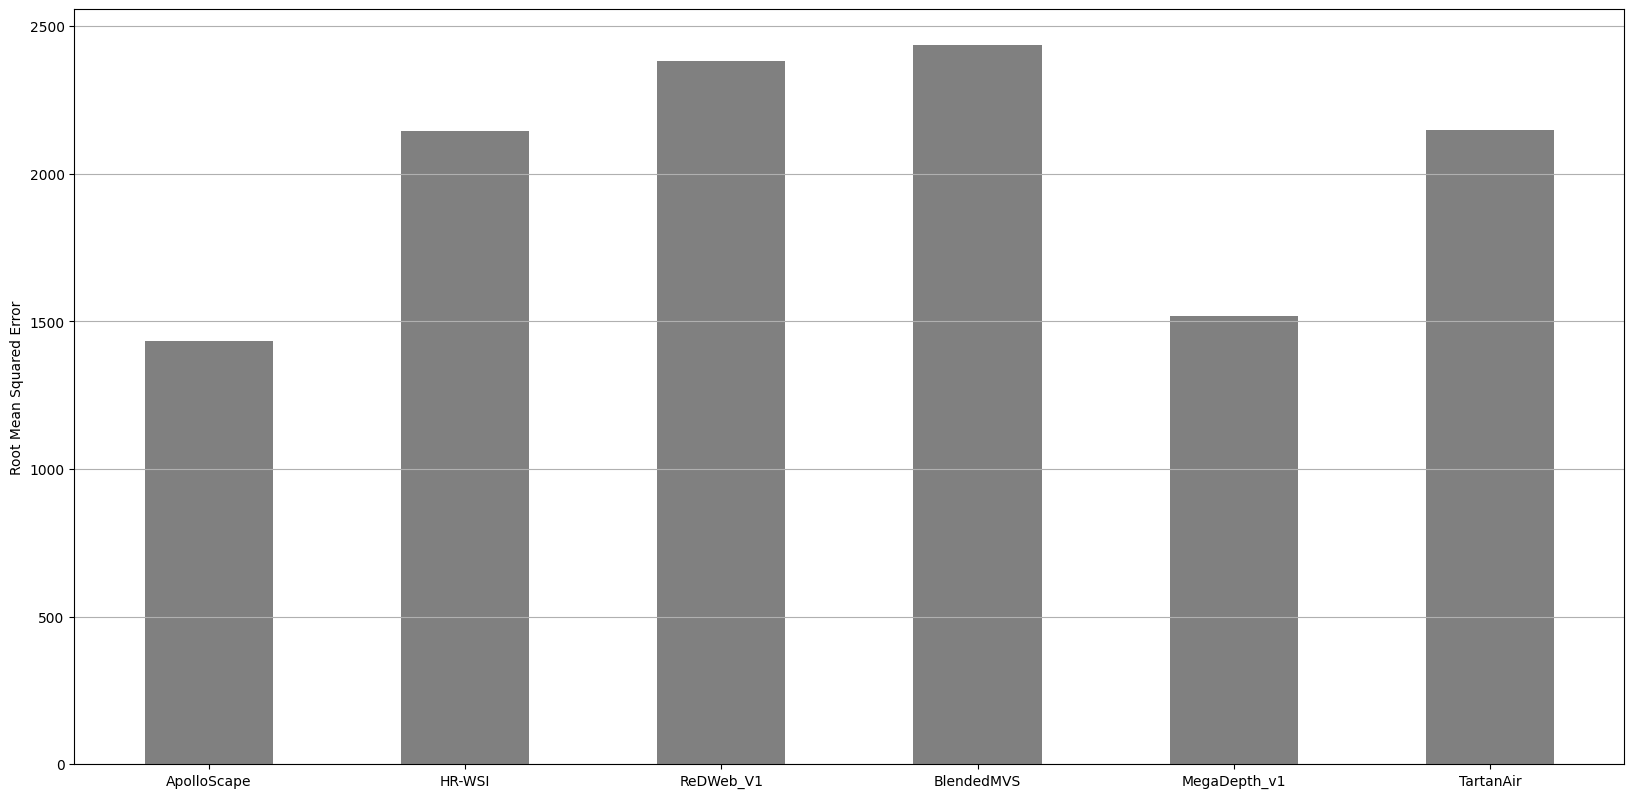

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(20, 10), dpi=100)
plt.bar(x=mean_dict.keys(), height=mean_dict.values(), width=0.5, color="grey")
plt.grid(True, axis="y")
plt.ylabel("Root Mean Squared Error")
plt.show()

# Failure cases

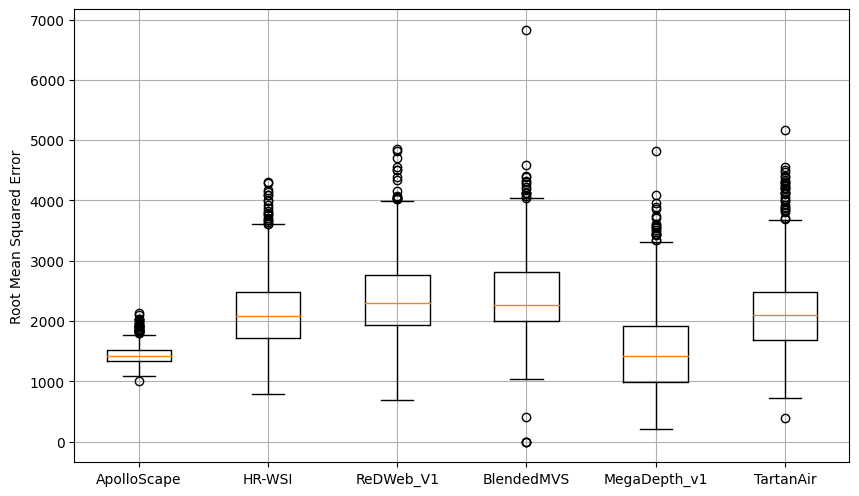

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot(loss_dict.values(), labels=loss_dict.keys())
plt.grid(True)
plt.ylabel("Root Mean Squared Error")
plt.savefig("rmse.jpg")
plt.show()

In [21]:
keys = list(imgs_dict.keys())
index = 5
k = keys[index]
v = imgs_dict[k]
logger.info(k)

fig, axs = plt.subplots(len(v), 2, figsize=(10, 20), dpi=100, sharex=True, sharey=True)
for i, img in enumerate(v):
    axs[i, 0].imshow(img[:, :, ::-1])
    axs[i, 1].imshow(predict(img, to_numpy=True))

IndexError: list index out of range

<IPython.core.display.Javascript object>

In [29]:
indices_report = {
    "ApolloScape": [0, 1, 9],
    "HR-WSI": [9, 7],
    "BlendedMVS": [1],
    "MegaDepth_v1": [0, 3],
    "TartanAir": [8],
}

<IPython.core.display.Javascript object>

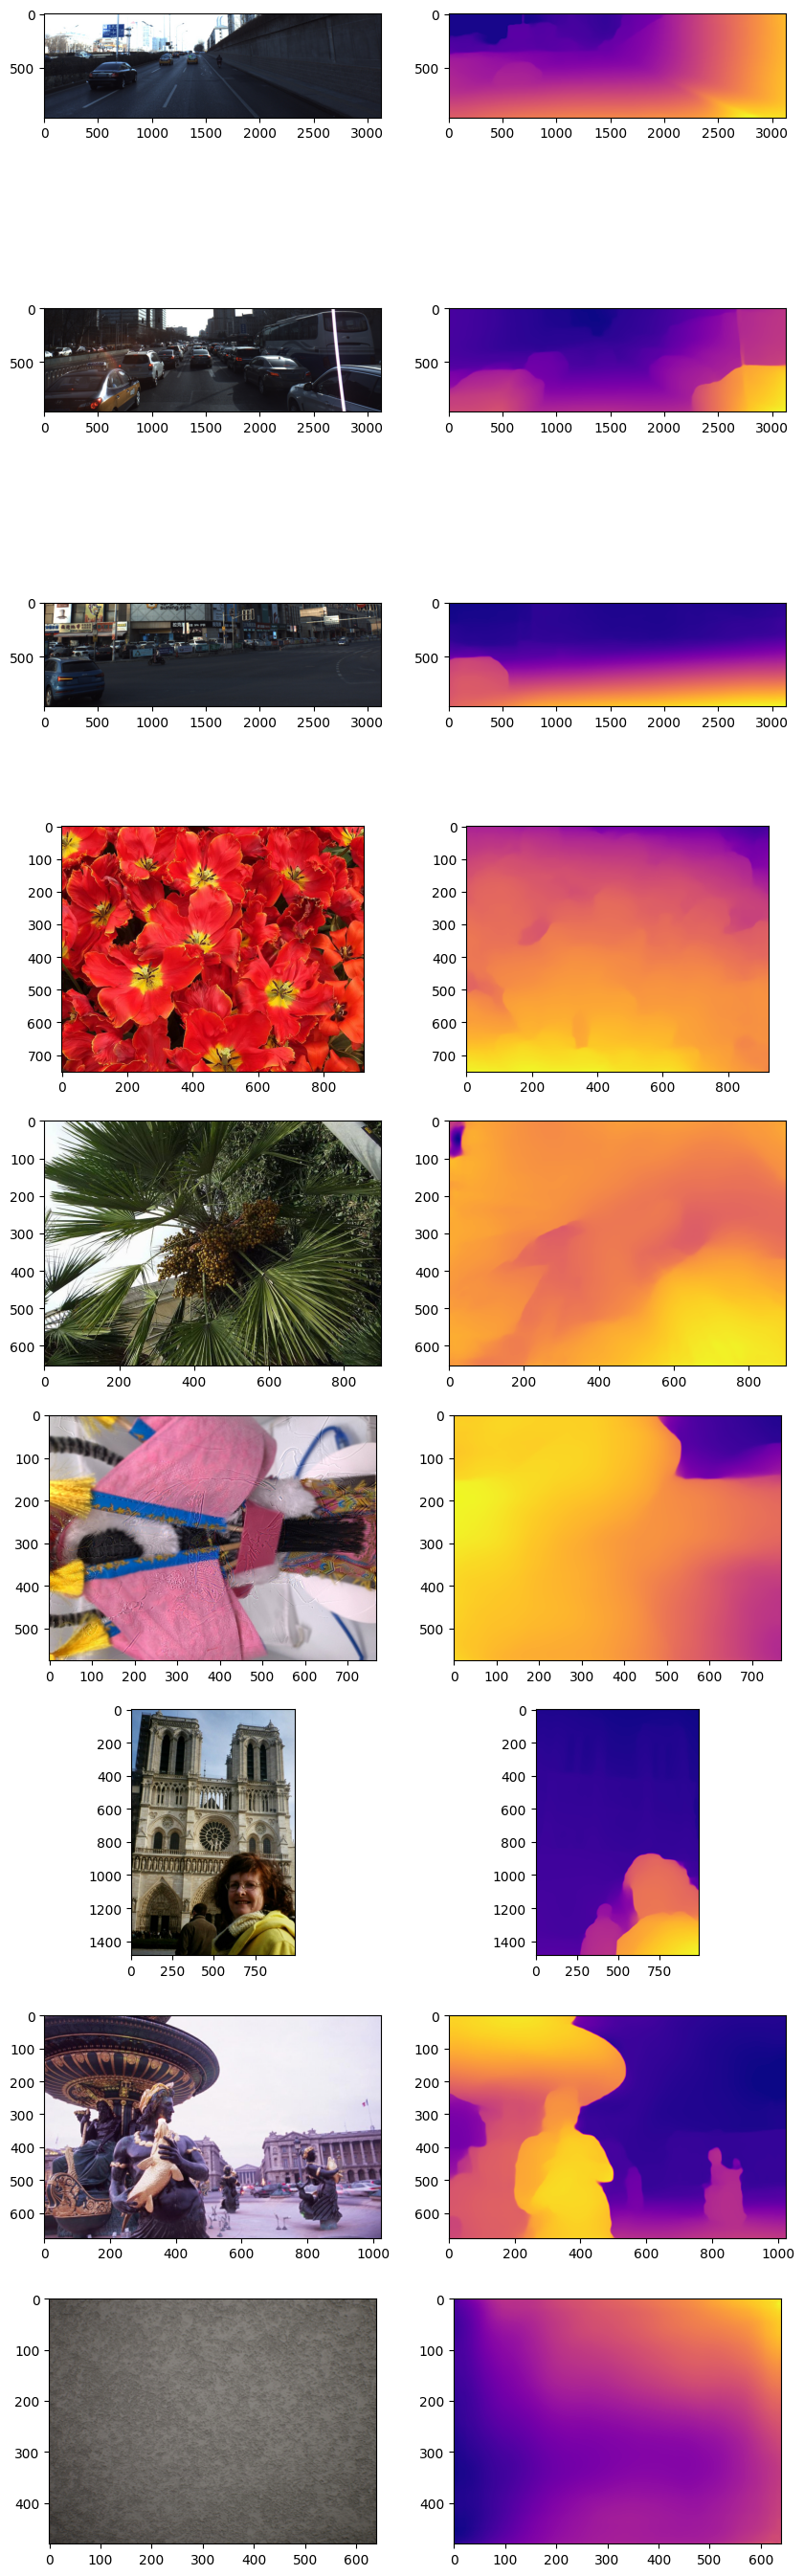

<IPython.core.display.Javascript object>

In [34]:
imgs = []
for k, v in indices_report.items():
    imgs.extend([imgs_dict[k][index] for index in v])
fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 36))
for i, img in enumerate(imgs):
    axs[i, 0].imshow(img[:, :, ::-1])
    axs[i, 1].imshow(predict(img, to_numpy=True))
plt.savefig("failure_cases.jpg")

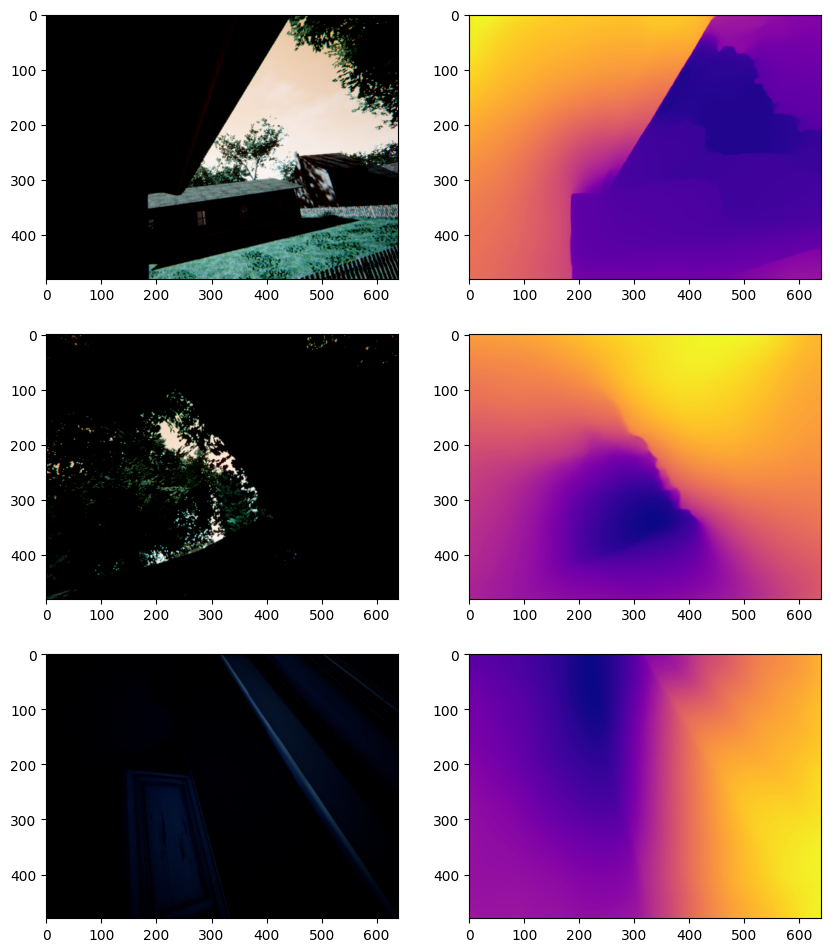

<IPython.core.display.Javascript object>

In [36]:
index = 0
height_per_image = 4
width = 10
key = list(indices_report.keys())[index]
img_indices = indices_report[key]
fig, axs = plt.subplots(
    len(img_indices),
    2,
    squeeze=False,
    figsize=(width, height_per_image * len(img_indices)),
)
for i, index in enumerate(img_indices):
    img = imgs_dict[k][index]
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(predict(img, to_numpy=True))